<a href="https://colab.research.google.com/github/manas-nambiar/NLP-Sentience-Assessment-Framework/blob/main/NLP_Sentience_Assessment_Framework_Reddit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis of Amazon Reviews
This program will utilize the VADER tool from Python's Natural Language Toolkit and the roBERTa-base model from Hugging Face.

To test these models, I will be using a collection of roughly 500,000 Amazon reviews from Kaggle. The dataset can be downloaded here: https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews

In [1]:
!pip install transformers
!pip install praw
!pip install torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 52.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 53.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.0/191.0 kB 4.3 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import nltk
import praw
import torch
import textwrap
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('vader_lexicon')

plt.style.use('ggplot')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [3]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
from tqdm.notebook import tqdm

In [4]:
user_agent = "sentiment-analyzer 1.0 by /u/nambzzz"
reddit = praw.Reddit(
    client_id = "CLIENT_ID",
    client_secret = "SECRET_ID",
    user_agent = user_agent
)

In [5]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [7]:
data_list = []
subreddit = 'ProgrammerHumor'

for submission in reddit.subreddit(subreddit).hot(limit=5):
  submission.comments.replace_more(limit=0)
  comments_list = []
  for comment in submission.comments:
    if comment.is_root:
      comments_list.append(comment.body)
  #comments_list = [comment.body for comment in comments]
  article_data = {
      "Title": submission.title,
      "Comments": comments_list
  }
  data_list.append(article_data)

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

In [8]:
df = pd.DataFrame(data_list)
df.head()

,Title,Comments
0,Why aren’t you playing by the rules of the game!,"[Out of the 7 reports on this post, I only agr..."
1,Simple Feature,[you thought you had edge cases covered\n\n*yo...
2,it's the most important skill,[I didn't find any posts that meet the matchin...
3,Manager does a little code cleanup...,"[Did he actually tweet this? Lmao, Reminds me ..."
4,Steal what is stolen,[Hi! This is our community moderation bot.\n\n...


In [9]:
def polarity_scores_roberta(comment):
  encoded_text = tokenizer(comment, max_length=512, truncation=True, return_tensors='pt')
  output = model(**encoded_text)
  scores = output[0][0].detach().numpy()
  scores = softmax(scores)
  scores_dict = {
        'roberta_neg':scores[0],
        'roberta_neu':scores[1],
        'roberta_pos':scores[2]
  }
  return scores_dict

In [10]:
result = {}
for i, row in tqdm(df.iterrows()):
  try:
    title = row['Title']
    comments = row['Comments']
    roberta_neu_scores = []
    roberta_pos_scores = []
    roberta_neg_scores = []
    for comment in comments:
      try:
        # Calculate sentiment score for each comment
        roberta_result = polarity_scores_roberta(comment)
        roberta_neu_scores.append(roberta_result['roberta_neu'])
        roberta_pos_scores.append(roberta_result['roberta_pos'])
        roberta_neg_scores.append(roberta_result['roberta_neg'])
      except RuntimeError:
        print(f'Error for a comment in "{title}"')
    if roberta_neu_scores:
      aggregated_roberta_neu_score = sum(roberta_neu_scores) / len(roberta_neu_scores)
    else:
      aggregated_roberta_neu_score = None

    if roberta_pos_scores:
      aggregated_roberta_pos_score = sum(roberta_pos_scores) / len(roberta_pos_scores)
    else:
      aggregated_roberta_pos_score = None

    if roberta_neg_scores:
      aggregated_roberta_neg_score = sum(roberta_neg_scores) / len(roberta_neg_scores)
    else:
      aggregated_roberta_neg_score = None

    # combined_result = {**vader_result_rename, **roberta_result}
    # result[myid] = combined_result
    result[title] = {
      'RoBERTa_Neu_Sentiment_Score': aggregated_roberta_neu_score,
      'RoBERTa_Pos_Sentiment_Score': aggregated_roberta_pos_score,
      'RoBERTa_Neg_Sentiment_Score': aggregated_roberta_neg_score,
  }
  except RuntimeError:
    print(f'Error for a comment in "{title}"')

0it [00:00, ?it/s]

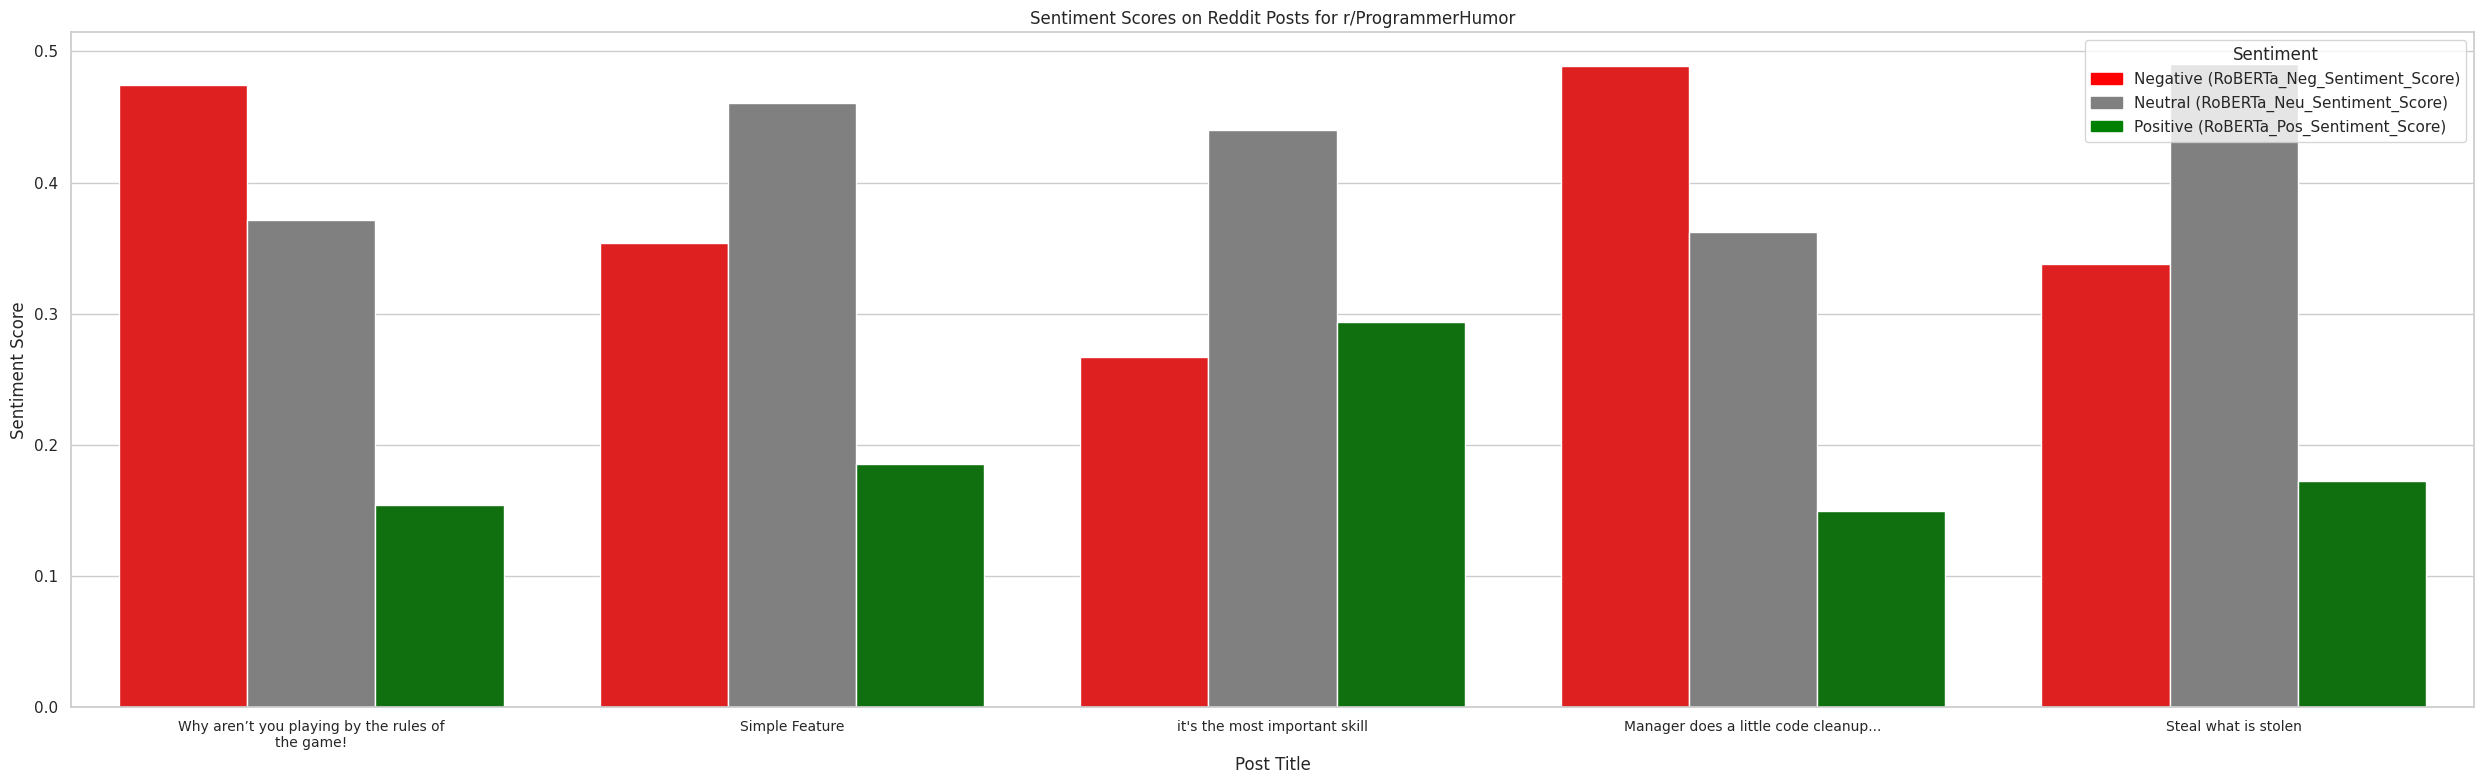

In [11]:
df = pd.DataFrame(result).T

df.fillna(0, inplace=True)

df.reset_index(inplace=True)
df.rename(columns={'index': 'Title'}, inplace=True)

# Melt the DataFrame to make it suitable for seaborn
df_melted = pd.melt(df, id_vars=['Title'], value_vars=['RoBERTa_Neg_Sentiment_Score','RoBERTa_Neu_Sentiment_Score', 'RoBERTa_Pos_Sentiment_Score'], var_name='Sentiment_Category', value_name='Sentiment_Score')

# Create a grouped bar plot
plt.figure(figsize=(25, 8))
sns.set(style="whitegrid")

# Customize the appearance of the grouped bar plot
custom_palette = {'RoBERTa_Neu_Sentiment_Score': 'grey', 'RoBERTa_Pos_Sentiment_Score': 'green', 'RoBERTa_Neg_Sentiment_Score': 'red'}
ax = sns.barplot(data=df_melted, x='Title', y='Sentiment_Score', hue='Sentiment_Category', palette=custom_palette)
plt.title(f'Sentiment Scores on Reddit Posts for r/{subreddit}')
plt.xlabel('Post Title')
plt.ylabel('Sentiment Score')
plt.xticks(rotation=0, fontsize=20)
legend_labels = {'RoBERTa_Neu_Sentiment_Score': 'Neutral', 'RoBERTa_Pos_Sentiment_Score': 'Positive', 'RoBERTa_Neg_Sentiment_Score': 'Negative'}
handles, _ = ax.get_legend_handles_labels()
custom_handles = [mpatches.Patch(color=custom_palette[label]) for label in df_melted['Sentiment_Category'].unique()]
plt.legend(title='Sentiment', loc='upper right', labels=[f'{legend_labels[label]} ({label})' for label in df_melted['Sentiment_Category'].unique()], handles=custom_handles)
ax.set_xticklabels([textwrap.fill(label, 40) for label in df['Title']], fontsize=10)
plt.tight_layout()
plt.show()